<a href="https://colab.research.google.com/github/IanTirok/Climate-change-tweets-analysis/blob/main/Climate_Change_Tweets_Classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Kneighbors classifier

In [1]:
!pip install wandb

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: kanoak (use `wandb login --relogin` to force relogin)


True

In [3]:

from wandb.keras import WandbCallback

In [4]:
config = wandb.config
wandb.init(project="Climate change Tweet Classification",
           notes="tweak baseline",
           tags=["baseline", "Remote Learning"],
           config=config)


In [5]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
# drive.mount('/content/drive')

In [6]:
train_df = pd.read_csv('/content/Clean classified data_kwisha.csv')
test_df = pd.read_csv('/content/Test (2).csv')
train_df['class'].value_counts()

renewable        2174
drought          1120
floods           1053
air_polutants     439
temperature       338
greentalk         302
Name: class, dtype: int64

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_df['class'] = le.fit_transform(train_df['class'])

In [8]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "cleaned tweets"
# Target: "class"

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df["clean_text"],
                                                  train_df["class"],
                                                  test_size=0.05,
                                                  shuffle=True,
                                                  stratify =train_df["class"] )
#import necessary libraries
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
#import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, )
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
test_df.head()


,Unnamed: 0,id,user,location,created_at,retweet_count,class,clean_text,date,year,month,hour,minute
0,0,1427551151273218048,re_search7AD5,"Santa Cruz de Tenerife, Spain",2021-08-17 08:41:31,0,NaN,antonioatanasv gretathunberg famous usa politi...,2021-08-17 08:41:31,2021,8,8,41
1,1,1427546953093685251,b_antunes,"Lisbon, Portugal",2021-08-17 08:24:50,0,NaN,gray whale death human climate change hurt oce...,2021-08-17 08:24:50,2021,8,8,24
2,2,1427546441736728600,mindsurftweet,Istanbul,2021-08-17 08:22:48,0,NaN,capitalism whats burn planet average people ht...,2021-08-17 08:22:48,2021,8,8,22
3,3,1427546209431048195,odilxx,Istanbul,2021-08-17 08:21:53,0,NaN,heartbreaking people post social medium climat...,2021-08-17 08:21:53,2021,8,8,21
4,6,1427540280975183873,PACJA1,Africa,2021-08-17 07:58:20,1,NaN,mithika mwenda say csos demand technologytrans...,2021-08-17 07:58:20,2021,8,7,58


In [10]:
# # Replace classes that are related
# train_df["class"].replace({"famine": "drought", "water": "floods"}, inplace=True)

In [11]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['clean_text'])
tokenizer.fit_on_texts(test_df['clean_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [12]:

# split the data into labels and features

X = X_train_vectors_tfidf
y = train_df['class']


#Defining the hyper parameters for the Knearest Neighbors Classifier
leaf_size = list(range(7,20))
n_neighbors = list(range(3,10))
p = [1,2]
metric = ['manhattan', 'euclidean', 'minkowski']
#Creating a dictionary with the hyperparameters
hyperparameters = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p=p,metric = metric)

#I used GridSearch to look for the best parameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

clf = RandomizedSearchCV(classifier, hyperparameters,cv=10)
clf = clf.fit(X_train_vectors_tfidf, y_train)

print('\n')

print(clf.best_params_)
print('\n')
#Creating a better model based on the parameters given to us by the gridsearch
modelone = KNeighborsClassifier(leaf_size = clf.best_params_['leaf_size'], n_neighbors = clf.best_params_['n_neighbors'], p = clf.best_params_['p'], metric = clf.best_params_['metric']).fit(X_train_vectors_tfidf, y_train)
modelone

# predicting using the model built

y_pred = modelone.predict(X_val_vectors_tfidf)

# comparing the actual and predicted

comparison_frame = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print('\n')
print(comparison_frame)
print('\n')
print(comparison_frame.describe())
# Evaluating the Algorithm
# ---

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('The F1 score is: ',metrics.f1_score(y_val, y_pred,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_pred,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')
print(classification_report(y_val, y_pred))



{'p': 1, 'n_neighbors': 9, 'metric': 'manhattan', 'leaf_size': 8}




      Actual  Predicted
2363       4          4
4060       4          4
129        4          1
3456       4          4
1477       2          2
...      ...        ...
4002       4          4
3419       4          4
1650       2          2
3357       4          4
55         5          2

[272 rows x 2 columns]


           Actual   Predicted
count  272.000000  272.000000
mean     2.676471    2.341912
std      1.516854    1.357230
min      0.000000    0.000000
25%      1.000000    1.000000
50%      3.000000    2.000000
75%      4.000000    4.000000
max      5.000000    5.000000
Mean Absolute Error: 0.6139705882352942
Mean Squared Error: 1.4375
Root Mean Squared Error: 1.1989578808281798
The accuracy of the model is  0.6948529411764706
The F1 score is:  0.6834076897485533
The recall score is  0.6948529411764706

 Confusion matrix
[[ 3 11  8  0  0  0]
 [ 0 49  6  0  1  0]
 [ 0  7 45  0  1  0]
 [ 0  9  3  3  0  0]
 [ 0

In [13]:
#define X variable for fitting of the new model
test_df

X_val = test_df['clean_text']

In [14]:
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) 

#fit the tfidf model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible

# predict using the test dataset
y_pred = modelone.predict(X_val_vectors_tfidf)
y_pred = le.inverse_transform(y_pred)
#Adding the predicted values to our dataset
test_df['class'] = y_pred


In [15]:
#Lets save our new dataset with class names

# test_df.to_csv('/content/drive/MyDrive/Module 2 groupwork Datasets/Test df with classes KNNclassifier.csv')

# Naive Bayes

In [16]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "cleaned tweets"
# Target: "class"

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df["clean_text"],
                                                  train_df["class"],
                                                  test_size=0.05,
                                                  shuffle=True,
                                                  stratify =train_df["class"] )
#import necessary libraries
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
#import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, )
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Gaussian NB

In [17]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Training and fitting the multinomial model
gausnb = GaussianNB()
gausnb.fit(X_train_vectors_tfidf.toarray(),y_train)
y_pred = gausnb.predict(X_val_vectors_tfidf.toarray())


#Checking performance our model with performance metrics.

comparison_frame = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print('\n')
print(comparison_frame)
print('\n')
print(comparison_frame.describe())
# Evaluating the Algorithm
# ---

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('The F1 score is: ',metrics.f1_score(y_val, y_pred,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_pred,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')
print(classification_report(y_val, y_pred))



      Actual  Predicted
818        0          0
2214       4          0
1069       2          5
2421       4          4
3106       4          4
...      ...        ...
267        2          2
1973       4          1
1323       2          2
492        3          0
1134       2          2

[272 rows x 2 columns]


           Actual   Predicted
count  272.000000  272.000000
mean     2.676471    2.794118
std      1.516854    1.488542
min      0.000000    0.000000
25%      1.000000    1.000000
50%      3.000000    4.000000
75%      4.000000    4.000000
max      5.000000    5.000000
Mean Absolute Error: 0.8014705882352942
Mean Squared Error: 2.1544117647058822
Root Mean Squared Error: 1.4677914581799016
The accuracy of the model is  0.6286764705882353
The F1 score is:  0.6191287206385304
The recall score is  0.6286764705882353

 Confusion matrix
[[10  3  1  2  6  0]
 [ 0 41  8  1  2  4]
 [ 0  7 23  0 19  4]
 [ 2  1  0  4  8  0]
 [ 3  5 12  4 85  0]
 [ 0  4  1  0  4  8]]

 Classification re

Bernoulli NB

In [18]:

# Training and fitting the bernoulli model
bernb = BernoulliNB()
bernb.fit(X_train_vectors_tfidf,y_train)
y_pred = bernb.predict(X_val_vectors_tfidf)


#Checking performance our model with performance metrics.

# comparison_frame = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print('\n')
print(comparison_frame)
print('\n')
print(comparison_frame.describe())
# Evaluating the Algorithm
# ---

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('The F1 score is: ',metrics.f1_score(y_val, y_pred,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_pred,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')
print(classification_report(y_val, y_pred))



      Actual  Predicted
818        0          0
2214       4          0
1069       2          5
2421       4          4
3106       4          4
...      ...        ...
267        2          2
1973       4          1
1323       2          2
492        3          0
1134       2          2

[272 rows x 2 columns]


           Actual   Predicted
count  272.000000  272.000000
mean     2.676471    2.794118
std      1.516854    1.488542
min      0.000000    0.000000
25%      1.000000    1.000000
50%      3.000000    4.000000
75%      4.000000    4.000000
max      5.000000    5.000000
Mean Absolute Error: 0.7720588235294118
Mean Squared Error: 2.264705882352941
Root Mean Squared Error: 1.5048939771136507
The accuracy of the model is  0.6691176470588235
The F1 score is:  0.5963367685674706
The recall score is  0.6691176470588235

 Confusion matrix
[[  1   1   0   0  20   0]
 [  0  48   1   0   7   0]
 [  0   1  27   0  25   0]
 [  0   2   4   0   9   0]
 [  0   1   2   0 106   0]
 [  0   5   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Multinomial NB

In [19]:

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

text_clf = Pipeline([('clf', MultinomialNB())])

tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]}

In [20]:
# Training and fitting the multinomial model
mnb = MultinomialNB()
mnb.fit( X_train_vectors_tfidf , y_train)
y_pred = mnb.predict(X_val_vectors_tfidf)

#Checking performance our model with performance metrics.

comparison_frame = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print('\n')
print(comparison_frame)
print('\n')
print(comparison_frame.describe())
# Evaluating the Algorithm
# ---

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('The F1 score is: ',metrics.f1_score(y_val, y_pred,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_pred,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')
print(classification_report(y_val, y_pred))



      Actual  Predicted
818        0          4
2214       4          4
1069       2          4
2421       4          4
3106       4          4
...      ...        ...
267        2          4
1973       4          4
1323       2          2
492        3          4
1134       2          2

[272 rows x 2 columns]


           Actual   Predicted
count  272.000000  272.000000
mean     2.676471    3.132353
std      1.516854    1.296085
min      0.000000    0.000000
25%      1.000000    2.000000
50%      3.000000    4.000000
75%      4.000000    4.000000
max      5.000000    5.000000
Mean Absolute Error: 0.6911764705882353
Mean Squared Error: 2.0441176470588234
Root Mean Squared Error: 1.4297264238513687
The accuracy of the model is  0.7022058823529411
The F1 score is:  0.6524489329641664
The recall score is  0.7022058823529411

 Confusion matrix
[[  2   1   0   0  19   0]
 [  0  47   1   0   7   1]
 [  0   2  30   0  21   0]
 [  0   1   1   2  11   0]
 [  0   1   0   0 108   0]
 [  0   3  

Since the accuracy is 60.7%, we will try to improve the model by hyperparameter tuning.

Hyperparameter Tuning

In [21]:
#Tuning hyperparameters and transforming features to a normal distribution
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_grid_NB = {'alpha': alphas}

NB_cls= MultinomialNB()

grid = GridSearchCV(estimator = NB_cls, param_grid = p_grid_NB, cv = 5)
grid.fit(X_train_vectors_tfidf, y_train)
grid.best_params_

{'alpha': 0.1}

In [22]:
# Training and fitting the multinomial model with hyperparameter tuned
mnb = MultinomialNB(alpha=0.1)
mnb.fit( X_train_vectors_tfidf , y_train)
y_pred = mnb.predict(X_val_vectors_tfidf)

#Checking performance our model with performance metrics.

comparison_frame = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print('\n')
print(comparison_frame)
print('\n')
print(comparison_frame.describe())
# Evaluating the Algorithm
# ---

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('The F1 score is: ',metrics.f1_score(y_val, y_pred,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_pred,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')
print(classification_report(y_val, y_pred))



      Actual  Predicted
818        0          0
2214       4          4
1069       2          3
2421       4          4
3106       4          4
...      ...        ...
267        2          2
1973       4          4
1323       2          2
492        3          0
1134       2          2

[272 rows x 2 columns]


           Actual   Predicted
count  272.000000  272.000000
mean     2.676471    2.735294
std      1.516854    1.496541
min      0.000000    0.000000
25%      1.000000    1.000000
50%      3.000000    4.000000
75%      4.000000    4.000000
max      5.000000    5.000000
Mean Absolute Error: 0.5367647058823529
Mean Squared Error: 1.463235294117647
Root Mean Squared Error: 1.2096426307458112
The accuracy of the model is  0.7610294117647058
The F1 score is:  0.7524510810413194
The recall score is  0.7610294117647058

 Confusion matrix
[[13  1  2  1  5  0]
 [ 0 48  5  1  0  2]
 [ 0  2 34  1 15  1]
 [ 4  2  0  5  4  0]
 [ 1  3  7  1 97  0]
 [ 0  4  0  0  3 10]]

 Classification rep

#Random_Forests_classifier_Climate_change_tweet_classification

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_df['class'] = le.fit_transform(train_df['class'])

In [24]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
#drive.mount('/content/drive')
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "cleaned tweets"
# Target: "class"

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df["clean_text"],
                                                  train_df["class"],
                                                  test_size=0.05,
                                                  shuffle=True,
                                                  stratify =train_df["class"] )
#import necessary libraries
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
#import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, )
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
# split the data into labels and features

# Creating a dictionary of parameters to tune
#
parameters = {'n_estimators': np.arange(10,13),
         'max_depth': np.arange(7,17)}

# Setting the number of folds to 5 and instantiating the model
# 

grid_search = RandomizedSearchCV(RandomForestClassifier(), parameters, cv = 5, return_train_score = True)

grid_search.fit(X_train_vectors_tfidf, y_train)
print(grid_search.best_params_)
print('\n')

#Lets see how the different max depth values compare to each other
print('how do the different depths compare to each other''\n')
for i in range(len(parameters['max_depth'])):
  print('parameters', grid_search.cv_results_['params'][i])
  print('mean Test scores:', grid_search.cv_results_['mean_test_score'][i])
  print('Rank:', grid_search.cv_results_['rank_test_score'][i])


print('\n')

dtree_model = RandomForestClassifier(n_estimators = grid_search.best_params_['n_estimators'], max_depth = grid_search.best_params_['max_depth']).fit(X_train_vectors_tfidf, y_train)
dtree_model
print('Training score:', dtree_model.score(X_train_vectors_tfidf, y_train))
print('Test score:', r2_score(y_val, y_pred))
y_pred = dtree_model.predict(X_train_vectors_tfidf)
#Random Forests model
comparison_frame = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print('\n')
print(comparison_frame)
print('\n')
print(comparison_frame.describe())

# Evaluating the Algorithm
# ---

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')

{'n_estimators': 12, 'max_depth': 16}


how do the different depths compare to each other

parameters {'n_estimators': 12, 'max_depth': 16}
mean Test scores: 0.6422225570423662
Rank: 1
parameters {'n_estimators': 10, 'max_depth': 16}
mean Test scores: 0.6129249573889051
Rank: 2
parameters {'n_estimators': 11, 'max_depth': 13}
mean Test scores: 0.6014726017722449
Rank: 3
parameters {'n_estimators': 12, 'max_depth': 10}
mean Test scores: 0.5395945118793141
Rank: 6
parameters {'n_estimators': 10, 'max_depth': 13}
mean Test scores: 0.5919715988812821
Rank: 4
parameters {'n_estimators': 11, 'max_depth': 10}
mean Test scores: 0.5236712401005716
Rank: 8
parameters {'n_estimators': 10, 'max_depth': 9}
mean Test scores: 0.5184288983266317
Rank: 9
parameters {'n_estimators': 11, 'max_depth': 7}
mean Test scores: 0.4879709585377567
Rank: 10
parameters {'n_estimators': 12, 'max_depth': 11}
mean Test scores: 0.5424898062960836
Rank: 5
parameters {'n_estimators': 11, 'max_depth': 9}
mean Test scores

ValueError: ignored

In [ ]:
from sklearn import metrics
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_pred))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_pred))
print('\n', 'Classification report')

In [ ]:
#define X variable for fitting of the new model
test_df

X_val = test_df['clean_text']

In [ ]:
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) 

#fit the tfidf model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible

# predict using the test dataset
y_pred = dtree_model.predict(X_val_vectors_tfidf)
y_pred = le.inverse_transform(y_pred)
#Adding the predicted values to our dataset
test_df['class'] = y_pred


In [ ]:
#Lets save our new dataset with class names

test_df.to_csv('/content/drive/MyDrive/Module 2 groupwork Datasets/Test df with classes RandomForestsclassifier.csv')

#Logistic Regression

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [27]:
train_df = pd.read_csv('/content/Clean classified data_kwisha.csv')
test_df = pd.read_csv('Test (2).csv')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.

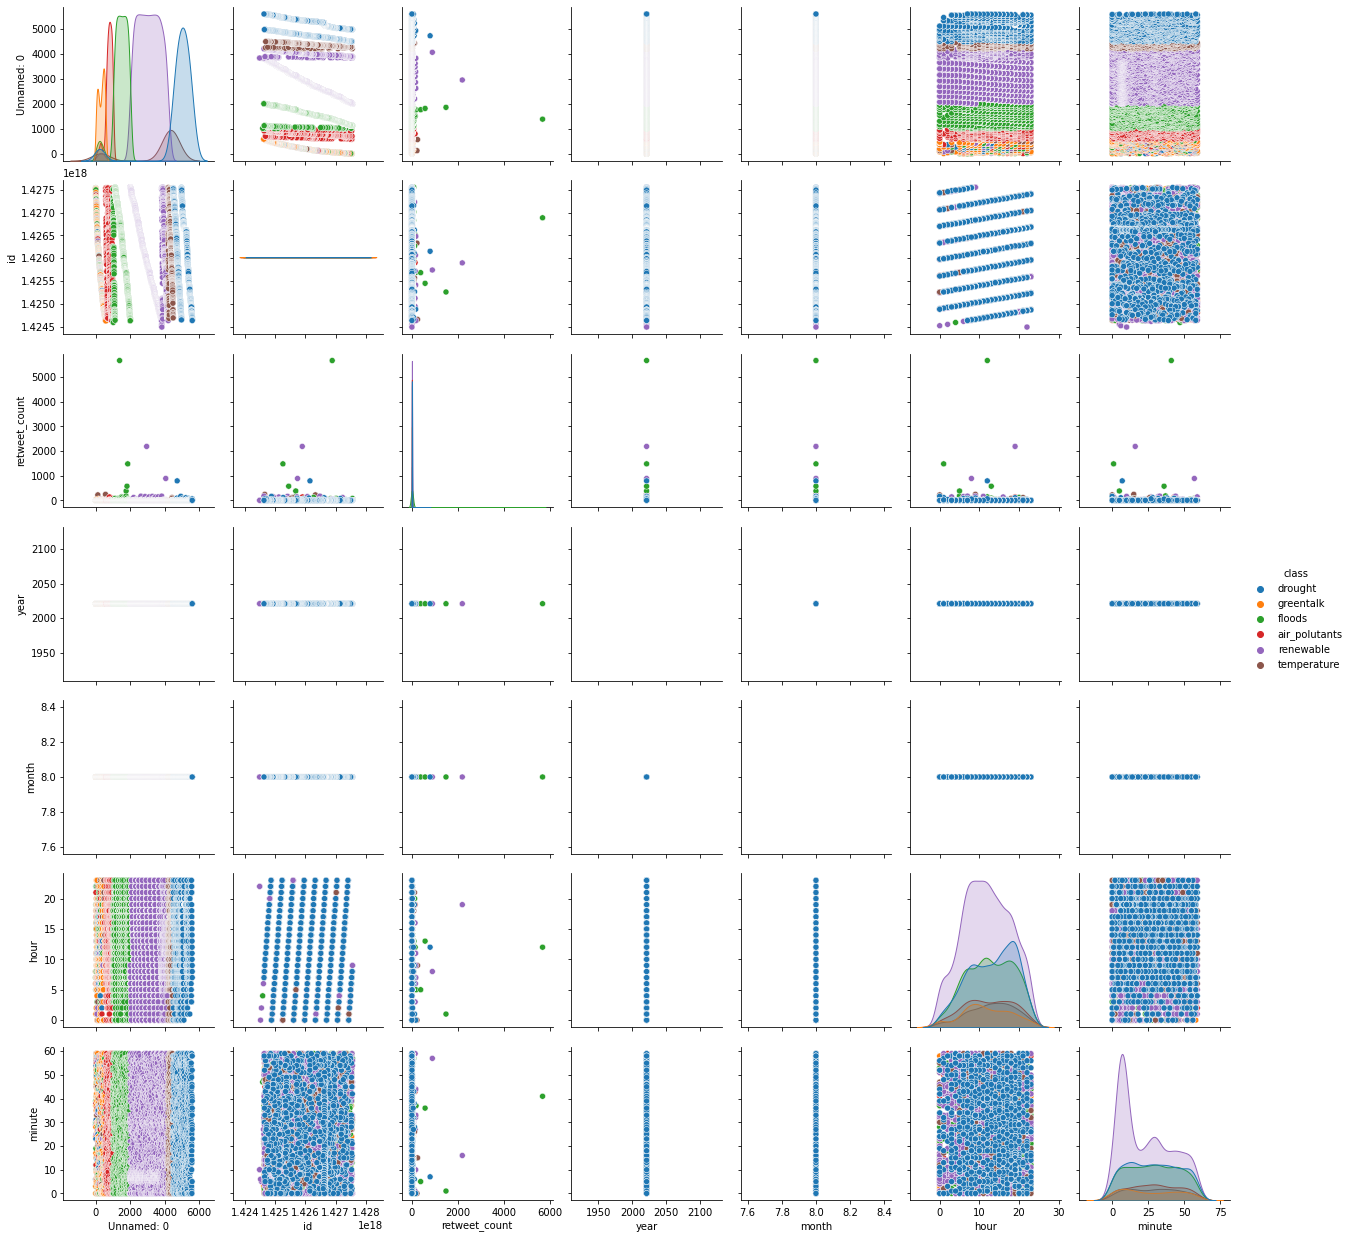

In [28]:
sns.pairplot(train_df, hue='class', size=2.5)

In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_df['class'] = le.fit_transform(train_df['class'])

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df["clean_text"],
                                                  train_df["class"],
                                                  test_size=0.05,
                                                  shuffle=True,
                                                  stratify =train_df["class"] )

In [31]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
#import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, )
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatibl

In [33]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]

 
baselog_accuracy = accuracy_score(y_val, y_predict)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_predict)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_predict))
print('The F1 score is: ',metrics.f1_score(y_val, y_predict,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_predict,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_predict))
print('\n', 'Classification report')
print(classification_report(y_val, y_predict))

Mean Absolute Error: 0.3161764705882353
Mean Squared Error: 0.8970588235294118
Root Mean Squared Error: 0.9471318934179187
The accuracy of the model is  0.875
The F1 score is:  0.8749458717586089
The recall score is  0.875

 Confusion matrix
[[ 17   0   1   0   4   0]
 [  0  47   1   1   6   1]
 [  0   2  47   1   3   0]
 [  3   0   0  12   0   0]
 [  0   3   4   0 102   0]
 [  0   0   0   4   0  13]]

 Classification report
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.90      0.84      0.87        56
           2       0.89      0.89      0.89        53
           3       0.67      0.80      0.73        15
           4       0.89      0.94      0.91       109
           5       0.93      0.76      0.84        17

    accuracy                           0.88       272
   macro avg       0.85      0.83      0.84       272
weighted avg       0.88      0.88      0.87       272



In [34]:
from six import StringIO

In [35]:
# Import the libraries
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE 
lr_tfidf = SVMSMOTE(random_state = 101)

# Choosing a sample
X_oversample_svm, y_oversample_svm = make_classification(n_samples=10000, n_features=2,
                                                         n_redundant=0, n_clusters_per_class=1,
                                                         weights=[0.99], flip_y=0, random_state=101)

# Perform Logistic Regression
X_oversample_svm, y_oversample_svm = lr_tfidf.fit_resample(X_train_vectors_tfidf, y_train)
classifier_svm = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
classifier_svm.fit(X_oversample_svm, y_oversample_svm)

#Predict y value for test dataset
y_predict = classifier_svm.predict(X_val_vectors_tfidf)
y_prob = classifier_svm.predict_proba(X_val_vectors_tfidf)[:,1]
 


from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_predict)))
print('The accuracy of the model is ',metrics.accuracy_score(y_val, y_predict))
print('The F1 score is: ',metrics.f1_score(y_val, y_predict,average='weighted'))
print('The recall score is ',metrics.recall_score(y_val, y_predict,average='weighted'))
print('\n', 'Confusion matrix')
print(confusion_matrix(y_val, y_predict))
print('\n', 'Classification report')
print(classification_report(y_val, y_predict))
#print(classification_report(y_test, classifier_svm.predict(X_test)))
accuracy_score(y_val, y_predict)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Mean Absolute Error: 0.3014705882352941
Mean Squared Error: 0.8088235294117647
Root Mean Squared Error: 0.8993461677306268
The accuracy of the model is  0.8676470588235294
The F1 score is:  0.8688976857634946
The recall score is  0.8676470588235294

 Confusion matrix
[[17  1  1  0  3  0]
 [ 0 48  1  1  5  1]
 [ 0  3 47  1  2  0]
 [ 3  0  0 12  0  0]
 [ 0  3  4  2 99  1]
 [ 0  0  0  4  0 13]]

 Classification report
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.87      0.86      0.86        56
           2       0.89      0.89      0.89        53
           3       0.60      0.80      0.69        15
           4       0.91      0.91      0.91       109
           5       0.87      0.76      0.81        17

    accuracy                           0.87       272
   macro avg       0.83      0.83      0.83       272
weighted avg       0.87      0.87      0.87       272



0.8676470588235294

## Transformers

## Transformers

In [36]:
! pip install ktrain

     |████████████████████████████████| 25.3 MB 90 kB/s 
     |████████████████████████████████| 6.8 MB 35.6 MB/s 
     |████████████████████████████████| 981 kB 36.6 MB/s 
     |████████████████████████████████| 263 kB 48.5 MB/s 
     |████████████████████████████████| 1.9 MB 49.5 MB/s 
     |████████████████████████████████| 1.2 MB 43.8 MB/s 
     |████████████████████████████████| 468 kB 33.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.5 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
  Created wheel for ktrain: filename=ktrain-0.27.2-py3-none-any.whl size=25283088 sha256=9ae6bf245c3a834967d3861e7360def32d2c8dbf7188e84e4f3c9f9240a3a8e3
  Stored in directory: /root/.cache/pip/wheels/88/be/4a/971c83a380a40f12e877f643ca1b94dc65f528f94c88dbcff7
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=334015a3f6681df9f86b6248c854d845ecf66e18ee17c5a91f295bb08897326e
  Stored in directory: /root/.cache/pip/wheels/f5/ac/f1/4e13d7aff0

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID';
os.environ['CUDA_VISIBLE_DEVICES']='0';

In [38]:
import pandas as pd
import ktrain
from ktrain import text

df=pd.read_csv('/content/Clean classified data_kwisha.csv')

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['class'] = le.fit_transform(df['class'])

In [40]:
data_texts = df["clean_text"].to_list() # Features (not-tokenized yet)
data_labels = df["class"].to_list() # Lables
from sklearn.model_selection import train_test_split

# # Split Train and Validation data
# train_texts, _texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)
X_train,X_test,y_train,y_test=train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)
# # Keep some data for inference (testing)
# train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

In [41]:
len(X_test),len(X_train),len(y_test),len(y_train)

(1086, 4340, 1086, 4340)

Build model with Transformer

In [42]:
# Build the model with pretrained model
model_name='distilbert-base-uncased'
categories=['renewable','drought','floods','air_polutants','temperature','greentalk']
#transformer
trans=text.Transformer(model_name,maxlen=512,class_names=categories)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

In [43]:
# Get the train and test data
train_data=trans.preprocess_train(X_train,y_train)
test_data=trans.preprocess_train(X_test,y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 19
	99percentile : 20


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 19
	99percentile : 20


Is Multi-Label? False


In [44]:
# We retrive the transformer distilbert classifier
model=trans.get_classifier()

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

In [45]:
# Get the learner
learner=ktrain.get_learner(model,train_data=train_data,val_data=test_data,batch_size=16)

In [46]:
# Train the model
learner.lr_find(show_plot=True,max_epochs=3) # we us ethe code to find the best learning rate

In [47]:
learner.fit_onecycle(0.003,1)



begin training using onecycle policy with max lr of 0.003...
272/272 [==============================] - 492s 2s/step - loss: 1.5748 - accuracy: 0.3912 - val_loss: 1.5520 - val_accuracy: 0.4079


In [48]:
# Test the metrics
learner.validate(class_names=categories)

               precision    recall  f1-score   support

    renewable       0.00      0.00      0.00        81
      drought       0.00      0.00      0.00       222
       floods       0.00      0.00      0.00       205
air_polutants       0.00      0.00      0.00        65
  temperature       0.41      1.00      0.58       443
    greentalk       0.00      0.00      0.00        70

     accuracy                           0.41      1086
    macro avg       0.07      0.17      0.10      1086
 weighted avg       0.17      0.41      0.24      1086



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0,   0,   0,   0,  81,   0],
       [  0,   0,   0,   0, 222,   0],
       [  0,   0,   0,   0, 205,   0],
       [  0,   0,   0,   0,  65,   0],
       [  0,   0,   0,   0, 443,   0],
       [  0,   0,   0,   0,  70,   0]])

In [49]:
X_test[553]

'farahaqli live one planet one atmosphere whether country https co szdpbatuvj'

Making predictions

In [50]:
predictor=ktrain.get_predictor(learner.model,prepoc=trans)

TypeError: ignored

In [ ]:
x='Six bodies of the flash flood victims have been recovered, leaving one tourist missing. The search and rescue operation continues as we reach out to next of kin to share details of (this) sad incident and plan together (our) next course of action.”'


In [ ]:
# We predict the random sentence 
predictor.predict(x)

In [ ]:
from wandb.keras import WandbCallback